In [132]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

In [133]:
#暗通道
def dackchannel(im,sz):
    dc=np.min(im,2)#？？？求RGB分量中最小值，存入和原始图像大小相同的灰度图中
    DC=cv2.erode(dc,np.ones((sz,sz)))# 对灰度图进行最小滤波，窗口为sz*sz
    return DC

In [134]:
def Alight1(im,DC):  #大气光成分A：借助暗通道，从有雾图中取值
    [h,w] = im.shape[:2]
    sz = h*w
    n = int(max(math.floor(sz/1000),1))#从暗通道图中提取前0.1%的像素个数
    DCv = DC.reshape(sz);#暗通道图（安亮度？？？）从小到大像素排序
    imv = im.reshape(sz,3);#原图分成三列排序？
    ind = (DCv.argsort())[sz-n::];  #sz-n????z对sz???从小到大排序后的索引值,取后n个值的位置
    
    #在原始有雾图像中寻找对应的最亮的值####暗通道是一列，原图三列怎么对应？
    A = np.zeros([1,3])
    A[0][0] = np.max(imv[ind][0])
    A[0][1] = np.max(imv[ind][1])
    A[0][2] = np.max(imv[ind][2])

    return A 

In [135]:
def Transmittanceestimate(im,A,sz): #透射率：
    w = 0.95;

    img = np.zeros(im.shape);
    for ind in range(0,3):
        img[:,:,ind] = im[:,:,ind]/A[0,ind]

    t = 1 - w*dackchannel(img,sz); #t=1-w*min窗口{min_c{Ic/Ac}}？？？
    return t

In [136]:
def Guidedfilter(im_gray,p,r,eps):  #引导滤波(I-灰度图/255;p-最小值处理后的按通道图/255.0)
    im=im_gray
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    
    var_I   = mean_II - mean_I*mean_I;
    cov_Ip = mean_Ip - mean_I*mean_p;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

In [137]:
def Recover(im,t,A,tx):  #去雾图J=(I-A)/max(t,t0)+A
    J = np.zeros(im.shape);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        J[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]

    return J

In [138]:
I = cv2.imread('C:/Users/user/Desktop/fog.jpg')
im = I.astype('float64')/255
im_gray= cv2.cvtColor(I, cv2.COLOR_BGR2GRAY).astype('float64')/255

In [139]:
DC = dackchannel(im,15); #暗通道
A1 = Alight1(im,DC);  #大气光成分A
te = Transmittanceestimate(im,A1,15);  #透射率t估计值
t = Guidedfilter(im_gray,te,20,0.0001);  #用引导滤波获得更加完善的t 
J1 = Recover(im,t,A1,0.25);  #去雾图J

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


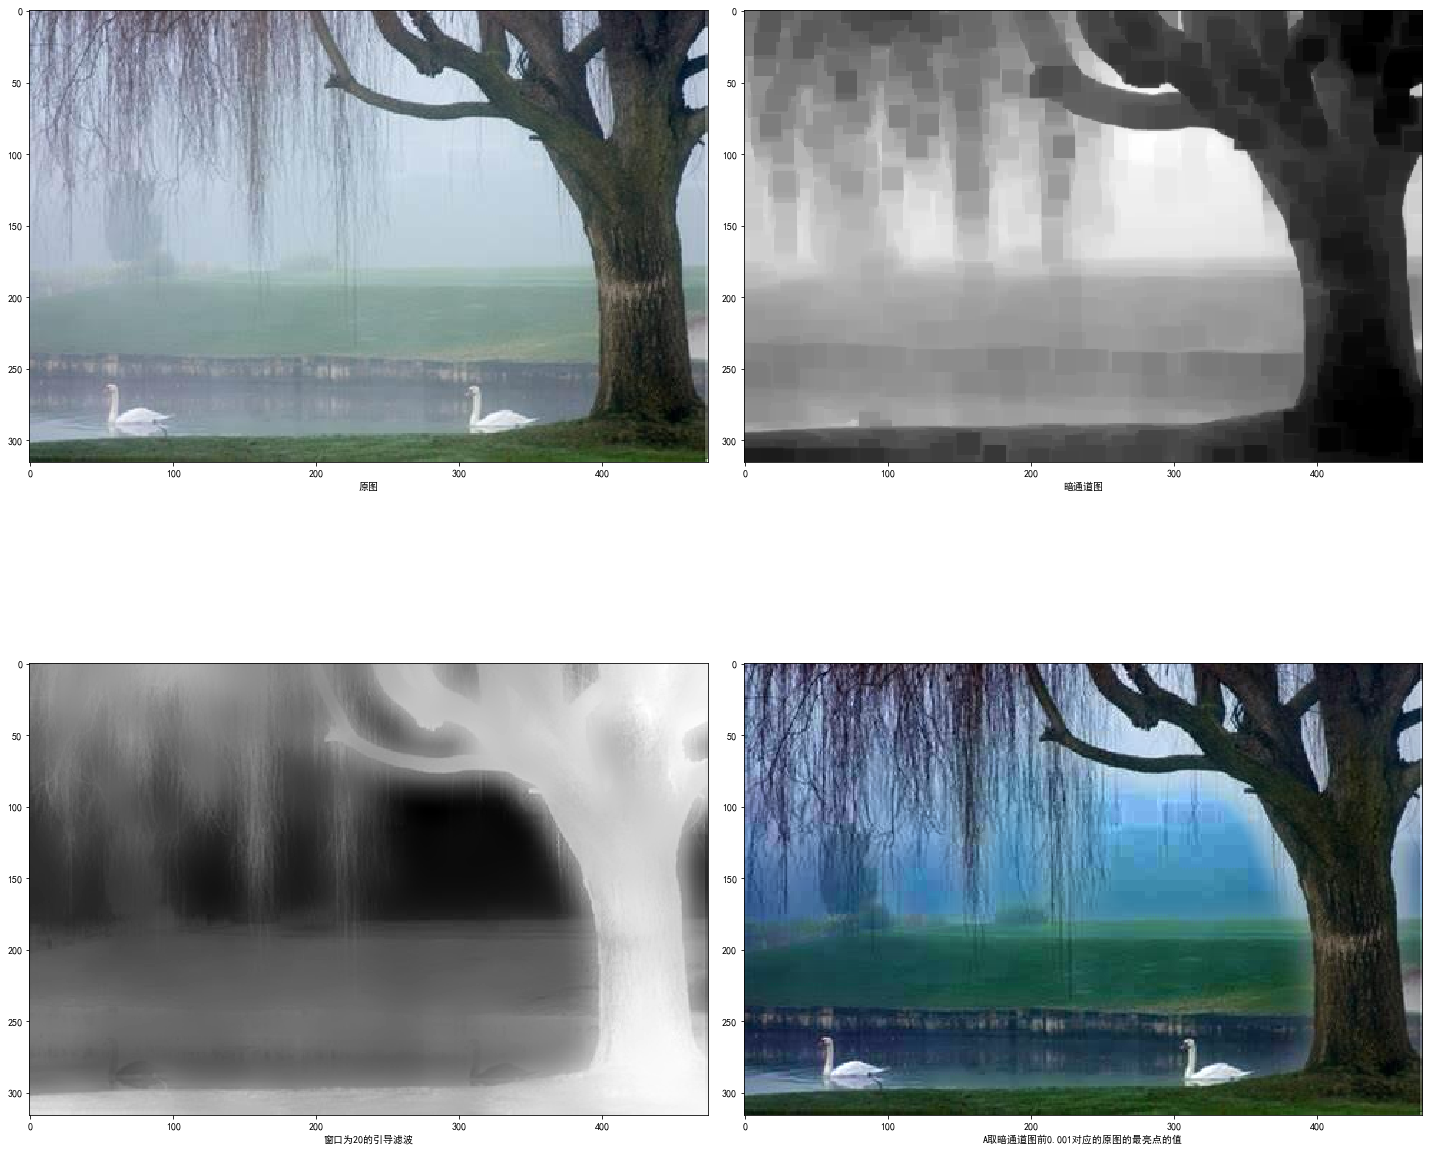

In [141]:
plt.figure(figsize=(20,20))
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.subplot(221), plt.imshow(I[:,:,[2,1,0]]),plt.xlabel('原图')
plt.subplot(222), plt.imshow(DC,cmap='gray'),plt.xlabel('暗通道图')
plt.subplot(223), plt.imshow(t,cmap='gray'),plt.xlabel('窗口为20的引导滤波')
plt.subplot(224), plt.imshow(J1[:,:,[2,1,0]]),plt.xlabel('A取暗通道图前0.001对应的原图的最亮点的值')
plt.tight_layout()
plt.show()